<a href="https://colab.research.google.com/github/DuongVinh2609/movie-genres-labelling/blob/main/Movies_labelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import cv2
import os
from nltk import wordpunct_tokenize
import re

### Download and unzip data from Drive

In [ ]:
!gdown 1hUqu1mbFeTEfBvl-7fc56fHFfCSzIktD

Downloading...
From (original): https://drive.google.com/uc?id=1hUqu1mbFeTEfBvl-7fc56fHFfCSzIktD
From (redirected): https://drive.google.com/uc?id=1hUqu1mbFeTEfBvl-7fc56fHFfCSzIktD&confirm=t&uuid=ee492fef-a86f-4618-b827-bbcf960a54b4
To: /content/ml1m.zip
100% 105M/105M [00:01<00:00, 68.9MB/s] 


In [ ]:
!unzip -qq ml1m.zip -d ml1m

### Preprocess data from raw data file


In [ ]:
users = pandas.read_csv('ml1m/content/dataset/users.dat', sep='::',
                        engine='python',
                        names=['userid', 'gender', 'age', 'occupation', 'zip']).set_index('userid')
ratings = pandas.read_csv('ml1m/content/dataset/ratings.dat', engine='python',
                          sep='::', names=['userid', 'movieid', 'rating', 'timestamp'])
movies_train = pandas.read_csv('ml1m/content/dataset/movies_train.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False).set_index('movieid')
movies_test = pandas.read_csv('ml1m/content/dataset/movies_test.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False).set_index('movieid')
movies_train['genre'] = movies_train.genre.str.split('|')
movies_test['genre'] = movies_test.genre.str.split('|')

# Add image path to dataframe
folder_img_path = 'ml1m/content/dataset/ml1m-images'
movies_train['id'] = movies_train.index
movies_train.reset_index(inplace=True)
movies_train['img_path'] = movies_train.apply(lambda row: os.path.join(folder_img_path, f'{row.id}.jpg'), axis = 1)

movies_test['id'] = movies_test.index
movies_test.reset_index(inplace=True)
movies_test['img_path'] = movies_test.apply(lambda row: os.path.join(folder_img_path, f'{row.id}.jpg'), axis = 1)


users.age = users.age.astype('category')
users.gender = users.gender.astype('category')
users.occupation = users.occupation.astype('category')
ratings.movieid = ratings.movieid.astype('category')
ratings.userid = ratings.userid.astype('category')

In [ ]:
movies_train

,movieid,title,genre,id,img_path
0,1650,Washington Square (1997),[Drama],1650,ml1m/content/dataset/ml1m-images/1650.jpg
1,185,"Net, The (1995)","[Sci-Fi, Thriller]",185,ml1m/content/dataset/ml1m-images/185.jpg
2,1377,Batman Returns (1992),"[Action, Adventure, Comedy, Crime]",1377,ml1m/content/dataset/ml1m-images/1377.jpg
3,3204,"Boys from Brazil, The (1978)",[Thriller],3204,ml1m/content/dataset/ml1m-images/3204.jpg
4,1901,Dear Jesse (1997),[Documentary],1901,ml1m/content/dataset/ml1m-images/1901.jpg
...,...,...,...,...,...
3101,2539,Analyze This (1999),[Comedy],2539,ml1m/content/dataset/ml1m-images/2539.jpg
3102,3038,"Face in the Crowd, A (1957)",[Drama],3038,ml1m/content/dataset/ml1m-images/3038.jpg
3103,1832,Heaven's Burning (1997),"[Action, Drama]",1832,ml1m/content/dataset/ml1m-images/1832.jpg
3104,657,Yankee Zulu (1994),"[Comedy, Drama]",657,ml1m/content/dataset/ml1m-images/657.jpg


In [ ]:
def preprocess(title):
  title = title.lower() # convert to lowercase
  title = re.sub(r'[^\w\s]', '', title) # remove punctuation
  title = title[:-5] # remove year
  return title

In [ ]:
class MLDataset(Dataset):
    def __init__(self, is_train=True):
        if is_train:
            self.data =  movies_train
        else:
            self.data = movies_test

        ### text
        # preprocess title
        self.data.processedTitle = [preprocess(str(title)) for title in self.data.title]

        # tf-idf count and smoothing tf-idf count
        self.vocab_size = 8192
        self.max_range_count = 5   # counting window of size 5
        self.pipe = Pipeline([('count', TfidfVectorizer(ngram_range=(1, self.max_range_count),
                                                   max_features=self.vocab_size,
                                                   lowercase=False)),  # already in lowercase
                         ('tf_idf', TfidfTransformer(sublinear_tf=True,
                                                     use_idf=True,
                                                     smooth_idf=True,))])
        self.pipe.fit([preprocess(str(title)) for title in movies_train.title]) # fit the tf-idf on training data statistics
        self.tfidf_encoding_title = self.pipe.transform(self.data.processedTitle).toarray()


        ### one hot encoding label genre
        with open('ml1m/content/dataset/genres.txt', 'r') as f:
            genre_all = f.readlines()
            genre_all = [x.replace('\n','') for x in genre_all]
        self.genre2idx = {genre:idx for idx, genre in enumerate(genre_all)}

    def __getitem__(self, index):
        title = self.tfidf_encoding_title[index]
        img_path = self.data.iloc[index].img_path
        genre = self.data.iloc[index].genre

        # preprocess title
        title_tensor = torch.from_numpy(title).float()

        # preprocess img
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
        else:
            img = np.random.rand(256,256,3)
        img = cv2.resize(img, (256,256))
        img_tensor = torch.from_numpy(img.transpose(2,0,1)).float()

        # preprocess label
        genre_vector = np.zeros(len(self.genre2idx))

        for g in genre:
            genre_vector[self.genre2idx[g]] = 1
        genre_tensor = torch.from_numpy(genre_vector).float()

        return title_tensor, img_tensor, genre_tensor

    def __len__(self):
        return len(self.data)

In [ ]:
train_set = MLDataset(is_train=True)
test_set = MLDataset(is_train=False)

BATCH_SIZE = 64
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE)

<ipython-input-7-afcf351283e7>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.data.processedTitle = [preprocess(str(title)) for title in self.data.title]


In [ ]:
[preprocess(str(title)) for title in movies_train.title][:10]  # test for preprocessing

['washington square',
 'net the',
 'batman returns',
 'boys from brazil the',
 'dear jesse',
 'jar the khomreh',
 'stag',
 'police academy 5 assignment miami beach',
 'end of the affair the',
 'another day in paradise']

In [ ]:
train_set.data.processedTitle[:10]  # Draw first 10 sample from train set after preprocessing

['washington square',
 'net the',
 'batman returns',
 'boys from brazil the',
 'dear jesse',
 'jar the khomreh',
 'stag',
 'police academy 5 assignment miami beach',
 'end of the affair the',
 'another day in paradise']

torch.Size([64, 8192]) torch.Size([64, 3, 256, 256]) torch.Size([64, 18]) 

Train sample
movieid                                          2522
title                              Airport '77 (1977)
genre                                         [Drama]
id                                               2522
img_path    ml1m/content/dataset/ml1m-images/2522.jpg
Name: 59, dtype: object


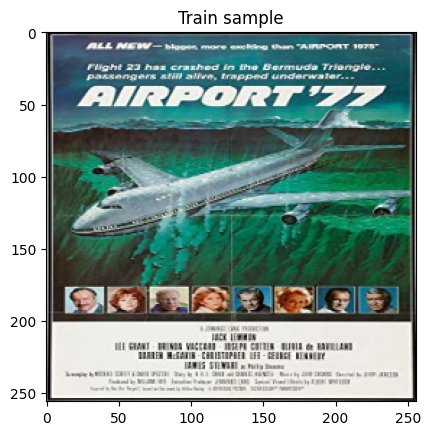

In [ ]:
import matplotlib.pyplot as plt

### Checking data shape and draw an example
for title_tensor, img_tensor, genre_tensor in train_dataloader:
    print(title_tensor.shape, img_tensor.shape, genre_tensor.shape, "\n")
    print("Train sample")
    index = 59
    print(movies_train.iloc[index])
    image_reorder = img_tensor[index].permute(1, 2, 0)
    bgr_to_rgb_image = image_reorder[:,:,[2,1,0]]
    plt.imshow(bgr_to_rgb_image/255)
    plt.title("Train sample")
    break


torch.Size([64, 8192]) torch.Size([64, 3, 256, 256]) torch.Size([64, 18]) 

Test sample
movieid                                          600
title                          Love and a .45 (1994)
genre                                     [Thriller]
id                                               600
img_path    ml1m/content/dataset/ml1m-images/600.jpg
Name: 31, dtype: object


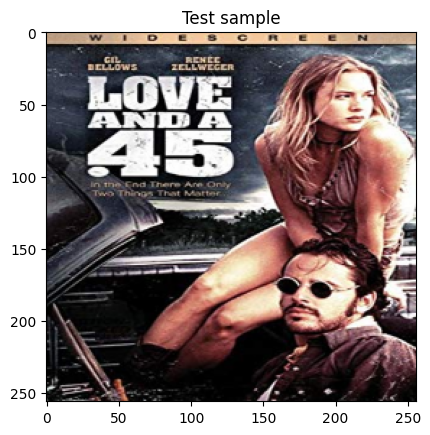

In [ ]:
for title_tensor, img_tensor, genre_tensor in test_dataloader:
    print(title_tensor.shape, img_tensor.shape, genre_tensor.shape, "\n")
    print("Test sample")
    index = 31
    print(movies_test.iloc[index])
    image_reorder = img_tensor[index].permute(1, 2, 0)
    bgr_to_rgb_image = image_reorder[:,:,[2,1,0]]
    plt.imshow(bgr_to_rgb_image/255)
    plt.title("Test sample")
    break

# Proposed Model


In [ ]:
with open('ml1m/content/dataset/genres.txt', 'r') as f:
    genre_all = f.readlines()
num_classes = len(genre_all)
num_classes

device = torch.device('cuda:0')

In [ ]:
def conv_block(num_filter):
    dropout_rate = 0.1
    return nn.Sequential(
            nn.Conv2d(in_channels=num_filter, out_channels=num_filter, kernel_size=(1, 1), stride=1, padding=(0, 0)),
            nn.BatchNorm2d(num_features=num_filter),
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_filter, out_channels=num_filter, kernel_size=(3, 3), stride=1, padding=(1, 1)),
            nn.BatchNorm2d(num_features=num_filter),
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_filter, out_channels=num_filter*4, kernel_size=(1, 1), stride=1, padding=(0, 0)),
            nn.BatchNorm2d(num_features=num_filter*4),
            nn.Dropout(dropout_rate),
            nn.ReLU(),
        )

In [ ]:
class ProposedModel(nn.Module):
    def __init__(self, num_classes):
        super(ProposedModel, self).__init__()
        ### Tensor Dimension: (batch_size, length), (batch_size, height, width), (batch_size, channel, height, width)
        ### title_tens: torch.Size([64, 8192])
        ### img_tens: torch.Size([64, 3, 256, 256])
        ### genre_tens: torch.Size([64, 18])

        ### Title
        self.title_model = nn.Sequential(
            nn.Linear(in_features=8192, out_features=512),
            nn.BatchNorm1d(num_features=512),
            nn.Dropout(0.01),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=18), # num_classes = 18
            nn.BatchNorm1d(num_features=18),
            nn.Dropout(0.01),
            nn.Softmax(dim=1),
        )

        ### Image
        # Init Block
        self.block0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7, 7), stride=2, padding=(3, 3)),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=(1, 1)),
        )

        # Block 1
        block1_filter_size = 64
        self.block1 = conv_block(num_filter=block1_filter_size)
        self.block1_projection = nn.Conv2d(in_channels=block1_filter_size, out_channels=block1_filter_size*4, kernel_size=(1, 1), stride=1, padding=(0, 0))

        # Block 2
        block2_filter_size = 256
        self.block2_downsampling = nn.Conv2d(in_channels=block2_filter_size, out_channels=block2_filter_size, kernel_size=(1, 1), stride=2, padding=(0, 0))
        self.block2 = conv_block(num_filter=block2_filter_size)
        self.block2_projection = nn.Conv2d(in_channels=block2_filter_size, out_channels=block2_filter_size*4, kernel_size=(1, 1), stride=2, padding=(0, 0))

        # Block 3
        block3_filter_size = 1024
        self.block3_downsampling = nn.Conv2d(in_channels=block3_filter_size, out_channels=block3_filter_size, kernel_size=(1, 1), stride=2, padding=(0, 0))
        self.block3 = conv_block(num_filter=block3_filter_size)
        self.block3_projection = nn.Conv2d(in_channels=block3_filter_size, out_channels=block3_filter_size*4, kernel_size=(1, 1), stride=2, padding=(0, 0))

        # Fully Connected layer
        self.fully_connected = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=4*1024*(16*16), out_features=128),
            nn.BatchNorm1d(num_features=128),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=18),  # num_classes = 18
            nn.BatchNorm1d(num_features=18),
            nn.Dropout(0.1),
            nn.Softmax(dim=1),

        )

    def forward(self, title_tens, img_tens):
        ### Tensor Dimension: (batch_size, height, width) (batch_size, channel, height, width)
        ### title_tens: torch.Size([64, 8192])
        ### img_tens: torch.Size([64, 3, 256, 256])
        ### genre_tens: torch.Size([64, 18])


        ### Image flow
        tensor = self.block0(img_tens)

        # Block 1
        identity = tensor
        tensor = self.block1(tensor)
        tensor = tensor + self.block1_projection(identity)

        # Block 2
        identity = tensor
        tensor = self.block2_downsampling(tensor)
        tensor = self.block2(tensor)
        tensor = tensor + self.block2_projection(identity)

        # Block 3
        identity = tensor
        tensor = self.block3_downsampling(tensor)
        tensor = self.block3(tensor)
        tensor = tensor + self.block3_projection(identity)

        # Fully connected layer
        img_output = self.fully_connected(tensor)


        ### Title flow
        title_output = self.title_model(title_tens)


        ### Merge two flows
        output = img_output + title_output


        return output


from torchsummary import summary
model = ProposedModel(num_classes).to(device)
# summary(model, input_size=[(8192,), (3, 256, 256)])

### Loss Function and Optimization Method



In [ ]:
### Loss function and Optimization method
from torch import optim

# Loss function
loss_function = nn.CrossEntropyLoss()

# Optimization method
learning_rate = 1e-3
weight_decay = 1e-4  # L2 Regularization
optimizer = optim.Adam(
    params=model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
)

### Model Training

In [ ]:
### Training model
num_epochs = 50
epochs_loss = dict()

for epoch in range(num_epochs):
  for idx, (title_tensor, img_tensor, genre_truth) in enumerate(train_dataloader):
    # Forward
    title_tensor = title_tensor.to(device)
    img_tensor = img_tensor.to(device)
    genre_truth = genre_truth.to(device)
    genre_predict = model(title_tensor, img_tensor)
    forward_loss = loss_function(genre_predict, genre_truth)

    # Backward
    optimizer.zero_grad()
    forward_loss.backward()
    optimizer.step()

  epochs_loss[epoch+1] = forward_loss.item()
  print(f"epoch: {epoch+1}, loss = {forward_loss.item():.4f}")

epoch: 1, loss = 4.2386
epoch: 2, loss = 4.0014
epoch: 3, loss = 3.8647
epoch: 4, loss = 3.7504
epoch: 5, loss = 3.6841
epoch: 6, loss = 3.6428
epoch: 7, loss = 3.5784
epoch: 8, loss = 3.5022
epoch: 9, loss = 3.5073
epoch: 10, loss = 3.4581
epoch: 11, loss = 3.4650
epoch: 12, loss = 3.4432
epoch: 13, loss = 3.3868
epoch: 14, loss = 3.3089
epoch: 15, loss = 3.2963
epoch: 16, loss = 3.2256
epoch: 17, loss = 3.2359
epoch: 18, loss = 3.1823
epoch: 19, loss = 3.2448
epoch: 20, loss = 3.2219
epoch: 21, loss = 3.1536
epoch: 22, loss = 3.2089
epoch: 23, loss = 3.1664
epoch: 24, loss = 3.1238
epoch: 25, loss = 3.1853
epoch: 26, loss = 3.1265
epoch: 27, loss = 3.1625
epoch: 28, loss = 3.0393
epoch: 29, loss = 3.0556
epoch: 30, loss = 3.0650
epoch: 31, loss = 3.0156
epoch: 32, loss = 3.0796
epoch: 33, loss = 3.0371
epoch: 34, loss = 3.0948
epoch: 35, loss = 3.0316
epoch: 36, loss = 3.0280
epoch: 37, loss = 3.0462
epoch: 38, loss = 2.9816
epoch: 39, loss = 3.0437
epoch: 40, loss = 3.0815
epoch: 41

### Evaluate Model

In [ ]:
!pip install -q torchmetrics
from torchmetrics.classification import MultilabelPrecision, MultilabelRecall, MultilabelF1Score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 52.8 MB/s eta 0:00:00


In [ ]:
num_classes = genre_tensor.shape[1]

total_precision = 0
total_recall = 0
total_f1 = 0

threshold = 0.5
precision = MultilabelPrecision(num_labels=num_classes, threshold=threshold, average='weighted').cuda()
recall = MultilabelRecall(num_labels=num_classes, threshold=threshold, average='weighted').cuda()
f1 = MultilabelF1Score(num_labels=num_classes, threshold=threshold, average='weighted').cuda()

for title_tensor, img_tensor, genre_truth in test_dataloader:
    title_tensor = title_tensor.cuda()
    img_tensor = img_tensor.cuda()
    genre_truth = genre_truth.cuda()

    genre_predict = model(title_tensor, img_tensor)

    precision_batch = precision(preds=genre_predict, target=genre_truth)
    recall_batch = recall(preds=genre_predict, target=genre_truth)
    f1_batch = f1(preds=genre_predict, target=genre_truth)

    total_precision += precision_batch
    total_recall += recall_batch
    total_f1 += f1_batch

print("Precision:", total_precision/len(test_dataloader))
print("Recall:", total_recall/len(test_dataloader))
print("F1:", total_f1/len(test_dataloader))


Precision: tensor(0.2271, device='cuda:0')
Recall: tensor(1., device='cuda:0')
F1: tensor(0.3460, device='cuda:0')


# Use real world data to model

Crime: 0.03
Thriller: 0.16
Fantasy: 0.01
Horror: 0.06
Sci-Fi: 0.05
Comedy: 0.03
Documentary: 0.02
Adventure: 0.01
Film-Noir: 0.03
Animation: 0.03
Romance: 0.08
Drama: 0.99
Western: 0.04
Musical: 0.19
Action: 0.07
Mystery: 0.03
War: 0.15
Children': 0.04

Predicted Labels: ['Drama']
Real Labels: ['Action', 'Drama']



Text(0.5, 1.0, 'Avenger Endgame (2019)')

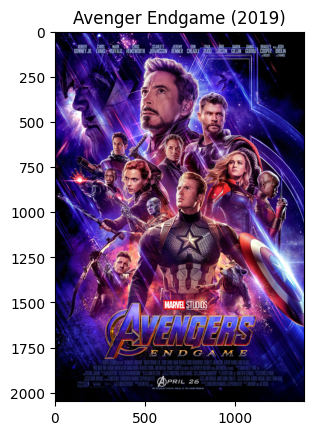

In [ ]:
########################################################
### User will type input ONLY ON THIS 3 LINES !!! ######
########################################################
input_image_path = "./avengerEndgame.jpg"   # Image should be jpg, png
input_title = "Avenger Endgame (2019)"
real_labels = ["Action", "Drama"] # Optional

### Preprocess input
# Title
processedTitle = train_set.pipe.transform([preprocess(input_title)]).toarray()

# Image
if os.path.exists(input_image_path):
    input_image = cv2.imread(input_image_path)
else:
    print("Not found Image Input, use random image")
    input_image = np.random.rand(256,256,3)
input_image_tensor = torch.from_numpy(cv2.resize(input_image, (256,256)).transpose(2,0,1)).float()


batch_title_input = torch.from_numpy(processedTitle).expand(BATCH_SIZE, -1).float()  # batch with same BATCH_SIZE elements
batch_image_input = torch.unsqueeze(input_image_tensor, 0).expand(BATCH_SIZE, -1, -1, -1).float() # batch with same BATCH_SIZE elements

try:  # Try load saved model
    model_load = ProposedModel(num_classes)
    model_load.load_state_dict(torch.load("./finalModel"))
    model_load.to(device)
    output = model_load(batch_title_input.to(device), batch_image_input.to(device))[0]
except Exception: # No saved model or failed to load saved model use trained model above
    output = model(batch_title_input.to(device), batch_image_input.to(device))[0]
# Genre map
genre_map = dict()
with open('ml1m/content/dataset/genres.txt', 'r') as f:
    genre = f.readline()
    while genre:
      genre_map[len(genre_map)] = genre[:-1]
      genre = f.readline()

# Model may not confident enough on real world data due to small training data
# So we set threshold to 0.3 to ease the model
threshold = 0.3
predicted_labels = []
for index in range(len(output)):
  if output[index] > threshold:
    predicted_labels.extend([genre_map[index]])

output_logits = []
for k, v in genre_map.items():
  output_logits.append([v, output[len(output_logits)].item()])

for entry in output_logits:
  print(entry[0]+":", round(entry[1], 2))
print("\nPredicted Labels:", predicted_labels)
if len(real_labels):
  print("Real Labels:", real_labels)
  print("")


plt.imshow(input_image[:,:,[2, 1, 0]])
plt.title(f"{input_title}")

In [ ]:
torch.save(model.state_dict(), "./finalModel")